### Gene ontology

In [8]:
import pandas as pd
from pathlib import Path
import random

random.seed(42)
path = Path("raw_data")

In [9]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

In [10]:
import networkx
import obonet

graph = obonet.read_obo(path/'Train/go-basic.obo')

# Number of nodes & edges
len(graph), graph.number_of_edges()

(43248, 84805)

In [11]:
# Create name mappings
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [12]:
# Randomly select a node
random_node = random.choice(list(graph))
random_node, id_to_name[random_node]

('GO:1990820', 'response to mitotic DNA integrity checkpoint signaling')

In [13]:
# Find edges to parent terms
for child, parent, key in graph.out_edges(random_node, keys=True):
    print(f'- {id_to_name[child]} -> {key} -> {id_to_name[parent]}')

- response to mitotic DNA integrity checkpoint signaling -> is_a -> response to DNA integrity checkpoint signaling
- response to mitotic DNA integrity checkpoint signaling -> is_a -> response to mitotic cell cycle checkpoint signaling


In [14]:
# Find edges to children terms
node = name_to_id['pilus']
for parent, child, key in graph.in_edges(node, keys=True):
    print(f'- {id_to_name[child]} <- {key} <- {id_to_name[parent]}')

- pilus <- part_of <- pilus shaft
- pilus <- part_of <- pilus tip
- pilus <- is_a <- type IV pilus
- pilus <- is_a <- curli
- pilus <- is_a <- type I pilus


In [15]:
# Find all superterms
sorted(id_to_name[superterm] for superterm in networkx.descendants(graph, random_node))

['biological_process',
 'cellular process',
 'cellular response to biotic stimulus',
 'cellular response to endogenous stimulus',
 'cellular response to stimulus',
 'response to DNA integrity checkpoint signaling',
 'response to biotic stimulus',
 'response to cell cycle checkpoint signaling',
 'response to endogenous stimulus',
 'response to mitotic cell cycle checkpoint signaling',
 'response to stimulus']

In [16]:
# Find all subterms
sorted(id_to_name[subterm] for subterm in networkx.ancestors(graph, node))

['curli', 'pilus shaft', 'pilus tip', 'type I pilus', 'type IV pilus']

In [17]:
# Find all paths to the root
paths = networkx.all_simple_paths(
    graph,
    source=random_node,
    target=name_to_id['biological_process']
)
for pth in paths:
    print('•', ' ⟶ '.join(id_to_name[node] for node in pth))

• response to mitotic DNA integrity checkpoint signaling ⟶ response to DNA integrity checkpoint signaling ⟶ response to cell cycle checkpoint signaling ⟶ cellular response to biotic stimulus ⟶ response to biotic stimulus ⟶ response to stimulus ⟶ biological_process
• response to mitotic DNA integrity checkpoint signaling ⟶ response to DNA integrity checkpoint signaling ⟶ response to cell cycle checkpoint signaling ⟶ cellular response to biotic stimulus ⟶ cellular response to stimulus ⟶ cellular process ⟶ biological_process
• response to mitotic DNA integrity checkpoint signaling ⟶ response to DNA integrity checkpoint signaling ⟶ response to cell cycle checkpoint signaling ⟶ cellular response to biotic stimulus ⟶ cellular response to stimulus ⟶ response to stimulus ⟶ biological_process
• response to mitotic DNA integrity checkpoint signaling ⟶ response to DNA integrity checkpoint signaling ⟶ response to cell cycle checkpoint signaling ⟶ cellular response to endogenous stimulus ⟶ response

### Train set

train_sequences.fasta contains the protein sequences for the training dataset.

In [18]:
def load_sequences(fasta_file):
    sequences = {}
    current_id = None
    with open(fasta_file, 'rt') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                # Extract the protein identifier from the line
                identifier = line[1:].split()[0]
                current_id = identifier
                sequences[current_id] = ''
            else:
                sequences[current_id] += line

    # Print number of protein sequences
    print(str(len(sequences)) + ' ids loaded.')
    return sequences


train_file = path/"Train/train_sequences.fasta"
train_sequences = load_sequences(train_file)

142246 ids loaded.


In [19]:
train_alphabet = list(set(''.join(train_sequences.values())))
print(f'Number of aminoacids: {len(train_alphabet)}, aminoacids: {"".join(sorted(train_alphabet))}')

Number of aminoacids: 25, aminoacids: ABCDEFGHIKLMNOPQRSTUVWXYZ


Max: 35375, min: 3.


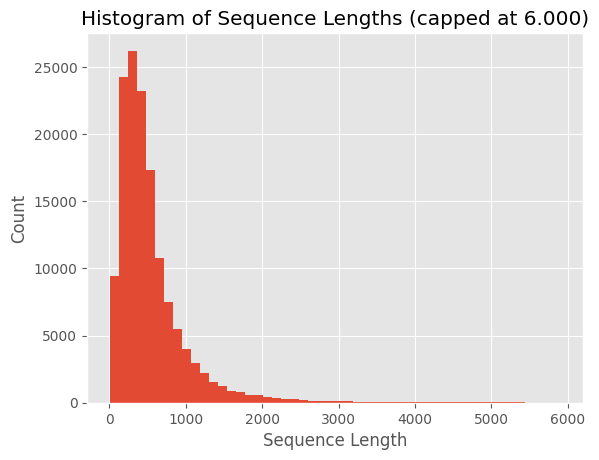

In [20]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

sequence_lengths = [len(sequence) for sequence in train_sequences.values()]

print(f'Max: {max(sequence_lengths)}, min: {min(sequence_lengths)}.')

# Plot histogram
plt.hist([x for x in sequence_lengths if x < 6000], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Histogram of Sequence Lengths (capped at 6.000)')
plt.show()

### Taxonomy

train_taxonomy.tsv contains the list of proteins and the species to which they belong.

In [21]:
taxonomy = pd.read_csv(path/'Train/train_taxonomy.tsv', sep='\t')
taxonomy.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


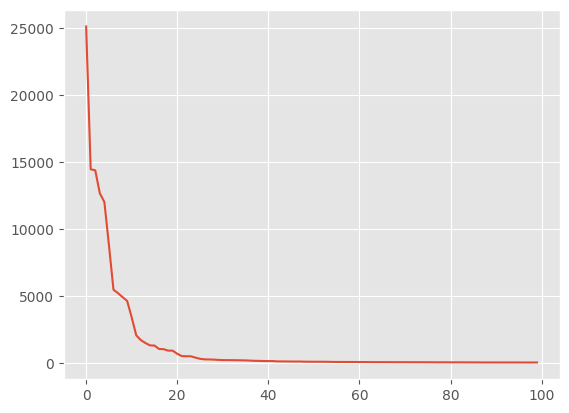

In [22]:
# Group the DataFrame by Taxon ID and count the number of occurrences
train_counts = taxonomy.groupby("taxonomyID").size().reset_index(name="Count")

# Sort the counts in descending order
train_counts = train_counts.sort_values("Count", ascending=False).reset_index(drop=True)

train_counts.head(100).Count.plot(kind='line')
plt.show()

### Labels
train_terms.tsv contains the list of annotated terms (ground truth) for the proteins in train_sequences.fasta.

In [23]:
train_labels = pd.read_csv(path/'Train/train_terms.tsv', sep='\t')
train_labels.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [24]:
len(train_labels), train_labels.term.nunique()

(5363863, 31466)

In [25]:
# Calculate min, max, median, and average number of GO terms per protein id
go_terms_per_protein = train_labels.groupby('EntryID')['term'].count()
min_go_terms_per_protein = go_terms_per_protein.min()
max_go_terms_per_protein = go_terms_per_protein.max()
median_go_terms_per_protein = go_terms_per_protein.median()
average_go_terms_per_protein = go_terms_per_protein.mean()

# Print the results
print("Min GO terms per protein ID:", min_go_terms_per_protein)
print("Max GO terms per protein ID:", max_go_terms_per_protein)
print("Median GO terms per protein ID:", median_go_terms_per_protein)
print("Average GO terms per protein ID:", average_go_terms_per_protein)

Min GO terms per protein ID: 2
Max GO terms per protein ID: 815
Median GO terms per protein ID: 24.0
Average GO terms per protein ID: 37.70835735275509


In [26]:
# Calculate min, max, median, and average number of unique protein id per GO term
proteins_per_go_term = train_labels.groupby('term')['EntryID'].nunique()
min_proteins_per_go_term = proteins_per_go_term.min()
max_proteins_per_go_term = proteins_per_go_term.max()
median_proteins_per_go_term = proteins_per_go_term.median()
average_proteins_per_go_term = proteins_per_go_term.mean()

print("Min unique protein ID per GO term:", min_proteins_per_go_term)
print("Max unique protein ID per GO term:", max_proteins_per_go_term)
print("Median unique protein ID per GO term:", median_proteins_per_go_term)
print("Average unique protein ID per GO term:", average_proteins_per_go_term)

Min unique protein ID per GO term: 1
Max unique protein ID per GO term: 92912
Median unique protein ID per GO term: 8.0
Average unique protein ID per GO term: 170.46535943558126


In [27]:
# Calculate min, max, median, and average number of unique protein ID per GO term for each aspect
unique_proteins_per_go_term = train_labels.groupby(['aspect', 'term'])['EntryID'].nunique()
min_proteins_per_go_term = unique_proteins_per_go_term.groupby('aspect').min()
max_proteins_per_go_term = unique_proteins_per_go_term.groupby('aspect').max()
median_proteins_per_go_term = unique_proteins_per_go_term.groupby('aspect').median()
average_proteins_per_go_term = unique_proteins_per_go_term.groupby('aspect').mean()

print("Min unique protein ID per GO term per aspect:")
for aspect, value in min_proteins_per_go_term.items():
    print(aspect, value)
print()
print("Max unique protein ID per GO term per aspect:")
for aspect, value in max_proteins_per_go_term.items():
    print(aspect, value)
print()
print("Median unique protein ID per GO term per aspect:")
for aspect, value in median_proteins_per_go_term.items():
    print(aspect, value)
print()
print("Average unique protein ID per GO term per aspect:")
for aspect, value in average_proteins_per_go_term.items():
    print(aspect, value)

Min unique protein ID per GO term per aspect:
BPO 1
CCO 1
MFO 1

Max unique protein ID per GO term per aspect:
BPO 92210
CCO 92912
MFO 78637

Median unique protein ID per GO term per aspect:
BPO 10.0
CCO 9.0
MFO 5.0

Average unique protein ID per GO term per aspect:
BPO 164.3284942447733
CCO 404.46973283733513
MFO 92.76218161683278


In [28]:
# Count the number of unique terms per aspect (ontology)
unique_terms_per_aspect = train_labels.groupby('aspect')['term'].nunique()

print("Unique terms per", unique_terms_per_aspect)

Unique terms per aspect
BPO    21285
CCO     2957
MFO     7224
Name: term, dtype: int64


BPO: top term has 92210 annotations, 500th top term has 1148 annotations.
CCO: top term has 92912 annotations, 500th top term has 96 annotations.
MFO: top term has 78637 annotations, 500th top term has 109 annotations.



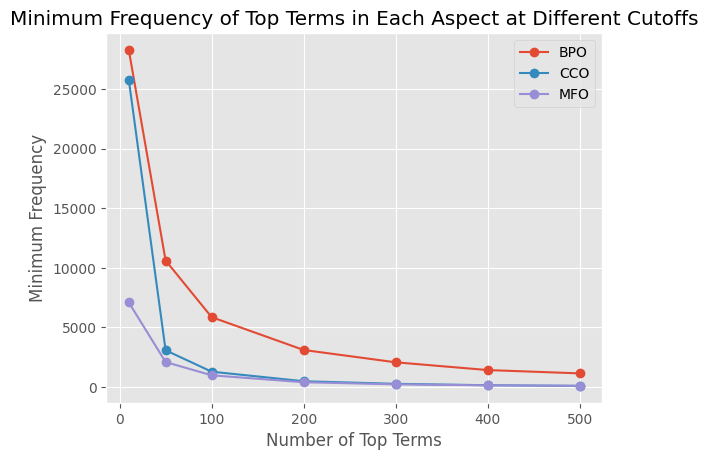

In [29]:
# Create histograms of GO terms per aspect
histograms = train_labels.groupby('aspect')['term'].value_counts()

# Convert the output into a readable chart
chart_data = []
for aspect, histogram in histograms.groupby(level=0):
    aspect_chart_data = []
    for nterms in [10, 50, 100, 200, 300, 400, 500]:
        min_freq = min(histogram.head(nterms))
        aspect_chart_data.append((nterms, min_freq))
    chart_data.append((aspect, aspect_chart_data))
    print(f'{aspect}: top term has {max(histogram)} annotations, 500th top term has {min(histogram.head(500))} annotations.')

print()
    
# Plot the chart
fig, ax = plt.subplots()

# Iterate over each aspect's data
for aspect, data in chart_data:
    x_values, y_values = zip(*data)
    ax.plot(x_values, y_values, marker='o', label=aspect)

# Set chart title and labels
ax.set_title("Minimum Frequency of Top Terms in Each Aspect at Different Cutoffs")
ax.set_xlabel("Number of Top Terms")
ax.set_ylabel("Minimum Frequency")

# Add legend
ax.legend()

# Show the chart
plt.show()

In [30]:
# Calculate the number of terms needed for a minimum of 50 annotations per term
num_terms_needed = []
for aspect, histogram in histograms.groupby(level=0):
    terms_needed = 0
    for term, freq in histogram.items():
        terms_needed += 1
        if freq < 50:
            num_terms_needed.append({aspect: terms_needed})
            break
            
print('This is how many terms we can keep if we set threshold at minimum 50 annotations per term:')
for x in num_terms_needed:
    print(x)

This is how many terms we can keep if we set threshold at minimum 50 annotations per term:
{'BPO': 4866}
{'CCO': 700}
{'MFO': 856}


### Test
testsuperset.fasta contains protein sequences on which the participants are asked to submit predictions.

In [31]:
from Bio import SeqIO

test_file = path/'Test (Targets)/testsuperset.fasta'

data = []
for record in SeqIO.parse(test_file, "fasta"):
    protein_id, taxon = record.description.split("\t")
    sequence = str(record.seq)
    data.append((protein_id, sequence, taxon))

test_sequences = pd.DataFrame(data, columns=["Protein ID", "Sequence", "Taxon"])
print(f'Loaded {len(test_sequences)} test sequences.\n')
test_sequences.head()

Loaded 141865 test sequences.



,Protein ID,Sequence,Taxon
0,Q9CQV8,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,10090
1,P62259,MDDREDLVYQAKLAEQAERYDEMVESMKKVAGMDVELTVEERNLLS...,10090
2,P68510,MGDREQLLQRARLAEQAERYDDMASAMKAVTELNEPLSNEDRNLLS...,10090
3,P61982,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,10090
4,O70456,MERASLIQKAKLAEQAERYEDMAAFMKSAVEKGEELSCEERNLLSV...,10090


In [32]:
len([x for x in test_sequences["Protein ID"].values if x in train_sequences.keys()])

73653

In [33]:
test_alphabet = list(set(''.join(test_sequences.Sequence.values)))
print(f'Number of aminoacids: {len(test_alphabet)}, aminoacids: {"".join(sorted(test_alphabet))}')

Number of aminoacids: 24, aminoacids: ABCDEFGHIKLMNPQRSTUVWXYZ


Max: 35213, min: 2.


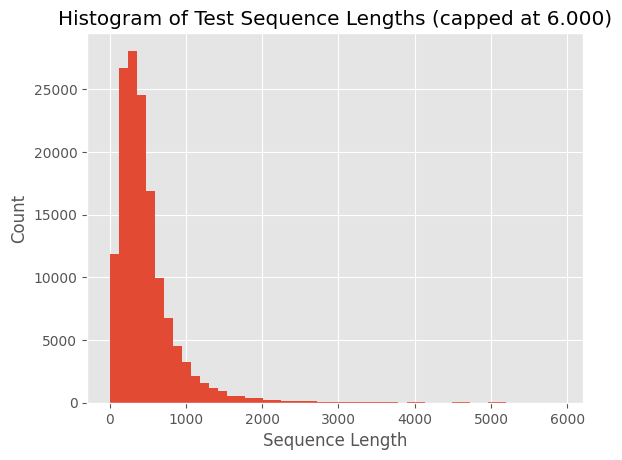

In [34]:
sequence_lengths = [len(sequence) for sequence in test_sequences.Sequence.values]

print(f'Max: {max(sequence_lengths)}, min: {min(sequence_lengths)}.')

# Plot histogram
plt.hist([x for x in sequence_lengths if x < 6000], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Histogram of Test Sequence Lengths (capped at 6.000)')
plt.show()

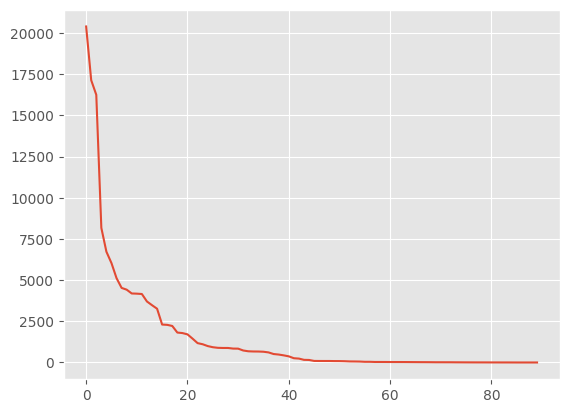

In [35]:
# Group the DataFrame by Taxon ID and count the number of occurrences
test_counts = test_sequences.groupby("Taxon").size().reset_index(name="Count")

# Sort the counts in descending order
test_counts = test_counts.sort_values("Count", ascending=False).reset_index(drop=True)

test_counts.head(100).Count.plot(kind='line');

In [36]:
train_counts['Taxon'] = train_counts.taxonomyID.astype('str')
compare_counts = pd.merge(test_counts, train_counts[['Taxon', 'Count']], how='left', on='Taxon', suffixes=['_test', '_train'])

In [37]:
compare_counts['Diff'] = compare_counts['Count_test'] - compare_counts['Count_train']
compare_counts = compare_counts.sort_values('Diff', ascending=False)
compare_counts.head()

,Taxon,Count_test,Count_train,Diff
5,9913,6035,1026.0,5009.0
9,224308,4191,396.0,3795.0
10,39947,4180,1311.0,2869.0
13,8355,3480,685.0,2795.0
1,10090,17141,14384.0,2757.0


### Submission
The list of predictions contains a list of pairs between protein targets and GO terms, followed by the probabilistic estimate of the relationship (one association per line). The target name must correspond to the target ID listed in the test set (in the FASTA header for each sequence). The GO ID must correspond to valid terms in GO's version listed in the Data section---invalid terms are automatically excluded from evaluation. Molecular Function (MF), Biological Process (BP), and Cellular Component (CC) subontologies of GO are to be combined in the prediction files, but they will be evaluated independently and combined at the end as described above. The score must be in the interval (0, 1.000] and contain up to 3 (three) significant figures. A score of 0 is not allowed; that is, the team should simply not list such pairs. In case the predictions in the submitted files are not propagated to the root of ontology, the predictions will be recursively propagated by assigning each parent term a score that is the maximum score among its children's scores. Finally, to limit prediction file sizes, one target cannot be associated with more than 1500 terms for MF, BP, and CC subontologies combined.

For any protein ID in the test superset, you must list a set of GO terms and assign your estimated probability. If a protein ID is not listed in your submitted file, the organizers will assume that all predictions are 0. The file should not contain a header, columns must be tab or space separated. An example submission file may look as follows:

In [38]:
pd.read_csv(path/'sample_submission.tsv', sep='\t', header=None).head()

,0,1,2
0,A0A0A0MRZ7,GO:0000001,0.123
1,A0A0A0MRZ7,GO:0000002,0.123
2,A0A0A0MRZ8,GO:0000001,0.123
3,A0A0A0MRZ8,GO:0000002,0.123
4,A0A0A0MRZ9,GO:0000001,0.123


### Naive submission

In [39]:
from collections import Counter

def assign_frequencies(train_df, test_sequences, num_terms):
    # Extract the frequencies of GO terms from the train dataframe
    term_frequencies = Counter(train_df['term'])

    # Select the top 'num_terms' frequent GO terms
    most_common_terms = [term for term, _ in term_frequencies.most_common(num_terms)]

    # Assign frequencies to test sequences
    test_assignments = []
    for sequence in test_sequences:
        term_counts = Counter(sequence)
        frequencies = [term_counts[term] for term in most_common_terms]
        test_assignments.append(frequencies)

    return test_assignments

num_terms = 1500

assignments = assign_frequencies(train_labels, test_sequences.Sequence.values, num_terms)

In [40]:
term_frequencies = Counter(train_labels['term'])
term_frequencies = pd.DataFrame(data=term_frequencies.most_common(num_terms), columns=['term', 'confidence'])
term_frequencies.confidence = term_frequencies.confidence / len(train_sequences)
term_frequencies.confidence.min(), term_frequencies.confidence.max()

(0.0030229321035389395, 0.6531782967535115)

In [41]:
term_frequencies['ids'] = [test_sequences['Protein ID'].values.tolist() for _ in range(len(term_frequencies))]
naive_sub = term_frequencies.explode('ids')
naive_sub.head()

,term,confidence,ids
0,GO:0005575,0.653178,Q9CQV8
0,GO:0005575,0.653178,P62259
0,GO:0005575,0.653178,P68510
0,GO:0005575,0.653178,P61982
0,GO:0005575,0.653178,O70456


### Evaluation

This competition focuses on predicting Gene Ontology (GO) terms for protein sequences in three different categories: Molecular Function (MF), Biological Process (BP), and Cellular Component (CC). Proteins in the test set, which were initially lacking experimentally determined functions, accumulate these annotations between the submission and evaluation phase. These proteins form three different test sets for evaluation, each corresponding to one of the GO categories. The evaluation metric is the maximum F-measure, a weighted average of precision and recall, calculated for each test set. The final performance is the arithmetic mean of the maximum F-measure of the three categories. Weights are based on the term's occurrence frequency in a large pool of proteins. The root terms have a weight of 0 as they appear in every protein's annotation, while terms deeper in the ontology are assigned larger weights as they appear less frequently and are harder to predict. The submission file should contain pairs of protein targets and GO terms along with their associated probability estimates. The evaluation is carried out on the combined set of no-knowledge and limited-knowledge protein targets.

Information accretion

IA.txt contains the information accretion (weights) for each GO term. These weights are used to compute weighted precision and recall, as described in the Evaluation section. Here is a discussion post by host on IA.

Information Accretion (IA) is a concept used in bioinformatics to quantify the amount of novel information a specific node or term brings into an ontology, assuming its parent terms are already annotated. In simpler terms, it's a way to assess how much "new knowledge" a term brings to the table if we already know about its parent terms. When dealing with a large ontology like protein functions, each term represents a certain aspect of a protein's function, and the 'parent' terms are more general functions that encompass the more specific 'child' terms. IA thus measures how much unique information is added by knowing about the specific child term, on top of what we already know from the parent terms.

To calculate IA, we use the observed annotations of terms in a dataset. Specifically, the probability of a term is estimated based on how often it appears in the dataset, as is the probability of its parent terms. The IA for a given term is then computed as the log ratio of the probability of the parent terms to the probability of the term itself. A key point to remember is that if a term hasn't appeared in the training set, we add an artificial count of 1 to prevent a zero probability. Also, the IA of a term could be zero if every protein annotated with the parent terms also has the term annotated, implying no additional information is brought by this term. Lastly, it's worth noting that terms deeper in the ontology usually have a lower IA, as they are more specific and thus less frequently annotated in proteins.